In [ ]:
!pip install texttable
!pip install texttable rasterio

In [ ]:
import ee
import geemap
import os
import matplotlib.image as mpimg
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import rasterio


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path configuration
out_dir = '/content/drive/My Drive/rec-2nd'
img_b2_path = os.path.join(out_dir, 'b2_sentinal2.tif')
img_b3_path = os.path.join(out_dir, 'b3_sentinal2.tif')
img_b4_path = os.path.join(out_dir, 'b4_sentinal2.tif')
resolution = os.path.join(out_dir, 'pla.tif')   #target shape

# TIFF image to resize
r_img_B2 = rasterio.open(img_b2_path)
r_img_B3 = rasterio.open(img_b3_path)
r_img_B4 = rasterio.open(img_b4_path)
img_B2 = r_img_B2.read(1)
img_B3 = r_img_B3.read(1)
img_B4 = r_img_B4.read(1)

# TIFF image with the resolution
r_resolution = rasterio.open(resolution)
img_with_scale = r_resolution.read(1)

# Image metadata
print('Band shape: ',img_B2.shape)
print('Band target shape: ',img_with_scale.shape)

# Concatenate the bands into a single numpy array
R = np.expand_dims(img_B4, axis=2)
G = np.expand_dims(img_B3, axis=2)
B = np.expand_dims(img_B2, axis=2)

old_img = np.concatenate((R,G), axis=2)
old_img = np.concatenate((old_img,B), axis=2)
print('Image to resize shape: ', old_img.shape)

Band shape:  (149, 309)
Band target shape:  (474, 983)
Image to resize shape:  (149, 309, 3)


In [ ]:
# Choose one method for resizing
nneighbor = cv2.INTER_NEAREST
bilineal = cv2.INTER_LINEAR
area_relation = cv2.INTER_AREA
bicubic = cv2.INTER_CUBIC
lanczos4 = cv2.INTER_LANCZOS4

# Change here the method
resize_method = nneighbor

# Set the new resolution
img_with_scale_size = (img_with_scale.shape[1],img_with_scale.shape[0])
new_img_B4 = cv2.resize(img_B4, img_with_scale_size, interpolation=resize_method).astype(np.uint16)
new_img_B3 = cv2.resize(img_B3, img_with_scale_size, interpolation=resize_method).astype(np.uint16)
new_img_B2 = cv2.resize(img_B2, img_with_scale_size, interpolation=resize_method).astype(np.uint16)
new_R = np.expand_dims(new_img_B4, axis=2)
new_G = np.expand_dims(new_img_B3, axis=2)
new_B = np.expand_dims(new_img_B2, axis=2)

new_img = np.concatenate((new_R,new_G), axis=2)
new_img = np.concatenate((new_img,new_B), axis=2)
print('Image to resize shape: ', new_img.shape)

Image to resize shape:  (474, 983, 3)


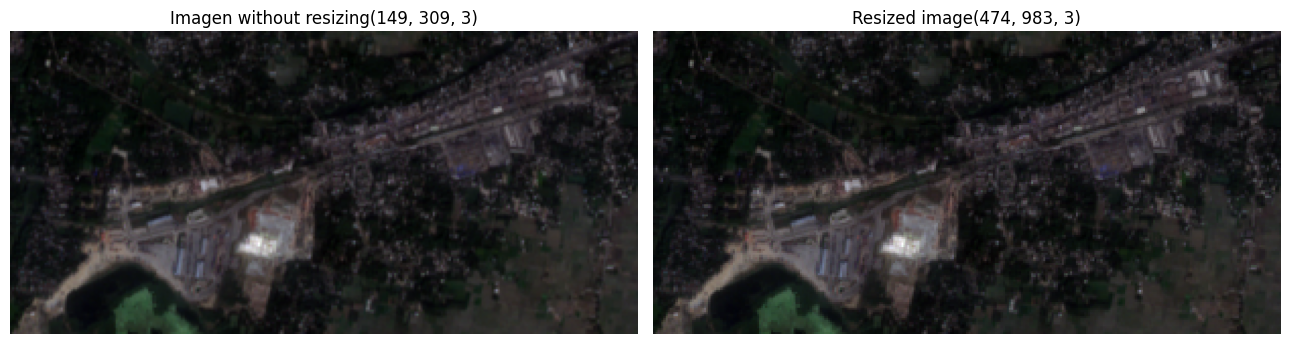

In [ ]:
# Image without resizing normalization
R = (((R-np.amin(R))/(np.amax(R)-np.amin(R)))*255).astype(int)
G = (((G-np.amin(G))/(np.amax(G)-np.amin(G)))*255).astype(int)
B = (((B-np.amin(B))/(np.amax(B)-np.amin(B)))*255).astype(int)
old_img_vis = np.concatenate((R,G), axis=2)
old_img_vis = np.concatenate((old_img_vis,B), axis=2)

# Resized image normalization
new_R = (((new_R-np.amin(new_R))/(np.amax(new_R)-np.amin(new_R)))*255).astype(int)
new_G = (((new_G-np.amin(new_G))/(np.amax(new_G)-np.amin(new_G)))*255).astype(int)
new_B = (((new_B-np.amin(new_B))/(np.amax(new_B)-np.amin(new_B)))*255).astype(int)
new_img_vis = np.concatenate((new_R,new_G), axis=2)
new_img_vis = np.concatenate((new_img_vis,new_B), axis=2)

# Container creation, to fit the plots
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(13, 10))

# Add the image without resizing to the container
ax0.imshow(old_img_vis)
ax0.set_title("Imagen without resizing" + str(old_img_vis.shape))
ax0.axis('off')

# Add the resized image to the container
ax1.imshow(new_img_vis)
ax1.set_title("Resized image" + str(new_img_vis.shape))
ax1.axis('off')

plt.tight_layout()

In [ ]:
l8_b2 = os.path.join(out_dir, 'B2.tif')
l8_b3 = os.path.join(out_dir, 'B3.tif')
l8_b4 = os.path.join(out_dir, 'B4.tif')

new_transform = rasterio.Affine(r_resolution.transform[0],r_resolution.transform[1],r_img_B2.transform[2],\
                      r_resolution.transform[3],r_resolution.transform[4],r_img_B2.transform[5])

with rasterio.open(
    l8_b4,
    'w',
    driver='GTiff',
    height=new_img_B4.shape[0],
    width=new_img_B4.shape[1],
    count=1,
    dtype=new_img_B4.dtype,
    crs='+proj=latlong',
    transform=new_transform,
) as dst:
    dst.write(new_img_B4, 1)

with rasterio.open(
    l8_b3,
    'w',
    driver='GTiff',
    height=new_img_B3.shape[0],
    width=new_img_B3.shape[1],
    count=1,
    dtype=new_img_B3.dtype,
    crs='+proj=latlong',
    transform=new_transform,
) as dst:
    dst.write(new_img_B3, 1)

with rasterio.open(
    l8_b2,
    'w',
    driver='GTiff',
    height=new_img_B2.shape[0],
    width=new_img_B2.shape[1],
    count=1,
    dtype=new_img_B2.dtype,
    crs='+proj=latlong',
    transform=new_transform,
) as dst:
    dst.write(new_img_B2, 1)

print('Downloaded band 2 in >> ', l8_b2)
print('Downloaded band 3 in >> ', l8_b3)
print('Downloaded band 4 in >> ', l8_b4)

Downloaded band 2 in >>  /content/drive/My Drive/rec-2nd/B2.tif
Downloaded band 3 in >>  /content/drive/My Drive/rec-2nd/B3.tif
Downloaded band 4 in >>  /content/drive/My Drive/rec-2nd/B4.tif
